## Import MIGraphX Python Library

In [11]:
import migraphx
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch

## Fetch U-NET ONNX Model

In [2]:
!wget -nc https://github.com/cagery/unet-onnx/raw/main/unet_13_256.onnx

File ‘unet_13_256.onnx’ already there; not retrieving.



## Load ONNX Model

In [3]:
model = migraphx.parse_onnx("unet_13_256.onnx")

In [4]:
model.compile(migraphx.get_target("gpu"))

## Print model parameters

In [5]:
print(model.get_parameter_names())
print(model.get_parameter_shapes())

['inputs']
{'inputs': float_type, {1, 3, 256, 256}, {196608, 65536, 256, 1}}


In [6]:
def preprocess(pil_img, newW, newH):
    w, h = pil_img.size
    assert newW > 0 and newH > 0, 'Scale is too small'
    pil_img = pil_img.resize((newW, newH))

    img_nd = np.array(pil_img)

    if len(img_nd.shape) == 2:
        img_nd = np.expand_dims(img_nd, axis=2)

    # HWC to CHW
    img_print = pil_img
    img_trans = img_nd.transpose((2, 0, 1))
    if img_trans.max() > 1:
        img_trans = img_trans / 255
        
    img_trans = np.expand_dims(img_trans, 0)

    return img_trans, img_print

def plot_img_and_mask(img, mask):
    classes = mask.shape[0] if len(mask.shape) > 3 else 1
    print(classes)
    fig, ax = plt.subplots(1, classes + 1)
    ax[0].set_title('Input image')
    ax[0].imshow(img)
    if classes > 1:
        for i in range(classes):
            ax[i+1].set_title(f'Output mask (class {i+1})')
            ax[i+1].imshow(mask[:, :, i])
    else:
        ax[1].set_title(f'Output mask')
        ax[1].imshow(mask[0,0])
    plt.xticks([]), plt.yticks([])
    plt.show()

(786432, 262144, 1024, 4)
(1, 3, 256, 256)


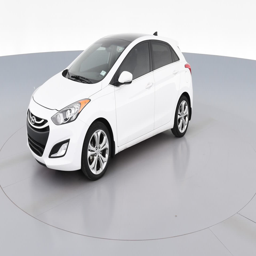

In [7]:
img = Image.open("./carsample.jpeg")
img, imPrint = preprocess(img, 256, 256)
input_im = np.zeros((1,3,256,256),dtype='float32') 
np.lib.stride_tricks.as_strided(input_im, shape=img.shape, strides=input_im.strides)[:] = img #getting correct stride
print(input_im.strides)
print(input_im.shape)
imPrint.show()

In [8]:
mask = model.run({'inputs':input_im}) # Your first inference would take longer than the following ones.
output_mask = np.array(mask[0])
output_mask.shape

(1, 1, 256, 256)

1


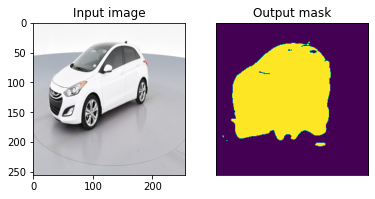

In [16]:
probs = torch.sigmoid(torch.from_numpy(output_mask))
full_mask = probs > 0.5
plot_img_and_mask(imPrint, full_mask)